## Application: Wave Damage To Cargo Ships
---

#### Variables:

+ type - type: "A" to "E".
+ year - year of construction: 1960–64, 65–69, 70–74, 75–79 (coded as "60", "65", "70", "75").
+ period - period of operation : 1960–74, 75–79.
+ service - aggregate months of service.
+ incidents - number of damage incidents.

#### Source:

ships - Ships Damage Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

McCullagh, P. and J. A. Nelder (1983) *Generalized Linear Models*, Second Edition, Chapman & Hall, Table 6.2, Page 205.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display

We consider the Poisson regression model:

\begin{align*}
 & \log(\text{expected number of damage incidents}) \\
 & = \beta_0 + \beta_1\log(\text{service}) + \beta_2(\text{ship type is B}) + \beta_3(\text{ship type is C}) + \beta_4(\text{ship type is D})+ \beta_5(\text{ship type is E}) \\
 & \quad + \beta_6(\text{year of construction: 1965-69}) + \beta_7(\text{year of construction: 1970-74})
    + \beta_8(\text{year of construction: 1975-79}) \\
 & \quad + \beta_9(\text{year of operation: 1975-79}).
\end{align*}


In [2]:
data = pd.read_csv('ships.csv', index_col=0)

We exclude the observations with `service` = 0.

In [3]:
data = data[data['service'] > 0]
log_service = np.log(data['service'].values).reshape((data.shape[0], 1))

Here we create dummy variables for ship types. The dummy variable for "A" is excluded.

In [4]:
str_type = data['type'].unique()
dummy_type = np.zeros((data.shape[0], str_type.size - 1))
for idx, ship_type in enumerate(str_type[1:]):
    dummy_type[:, idx] = (data['type'] == ship_type).values

Then we create dummy variables for years of construction. The dummy variable for 1960-64 is excluded.

In [5]:
str_year = data['year'].unique()
dummy_year =  np.zeros((data.shape[0], str_year.size - 1))
for idx, construction_year in enumerate(str_year[1:]):
    dummy_year[:, idx] = (data['year'] == construction_year).values

We create the dummy variable for period of operation.

In [6]:
str_period = data['period'].unique()
dummy_period =  np.zeros((data.shape[0], str_period.size - 1))
for idx, operation_period in enumerate(str_period[1:]):
    dummy_period[:, idx] = (data['period'] == operation_period).values

Finally we create the matrix of the independent variables `X` and the vector of the dependent variable `y`.

In [7]:
X = np.hstack((np.ones((data.shape[0],1)), log_service, dummy_type, dummy_year, dummy_period))
y = data['incidents'].values
var_names = ['constant', 'log_service', 'B', 'C', 'D', 'E', '65-69', '70-74', '75-79', 'operation']

In [8]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [9]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123,
                      nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]
Sampling 4 chains: 100%|██████████| 24000/24000 [02:34<00:00, 96.33draws/s]


In [10]:
post_stats = pm.summary(trace)
post_stats.index = var_names
display(post_stats)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
constant,-5.638051,0.875254,0.011570,-7.369927,-3.953894,6014.894457,1.000639
log_service,0.905831,0.102162,0.001336,0.706013,1.105339,6480.681028,1.000688
B,-0.346251,0.271366,0.003143,-0.885725,0.165154,9703.608408,1.000498
C,-0.794647,0.344754,0.003083,-1.461536,-0.106950,13099.706273,0.999953
D,-0.154510,0.299766,0.002640,-0.740819,0.436521,10745.918854,0.999950
E,0.269738,0.240498,0.002132,-0.205269,0.734951,12009.176911,1.000075
65-69,0.665087,0.155943,0.001712,0.366969,0.978248,9756.553250,1.000018
70-74,0.763043,0.178596,0.002076,0.400171,1.093937,8410.471297,1.000199
75-79,0.366104,0.250522,0.002654,-0.126218,0.850843,9335.482107,1.000221
operation,0.370223,0.118718,0.000941,0.141954,0.611404,14845.682100,1.000059


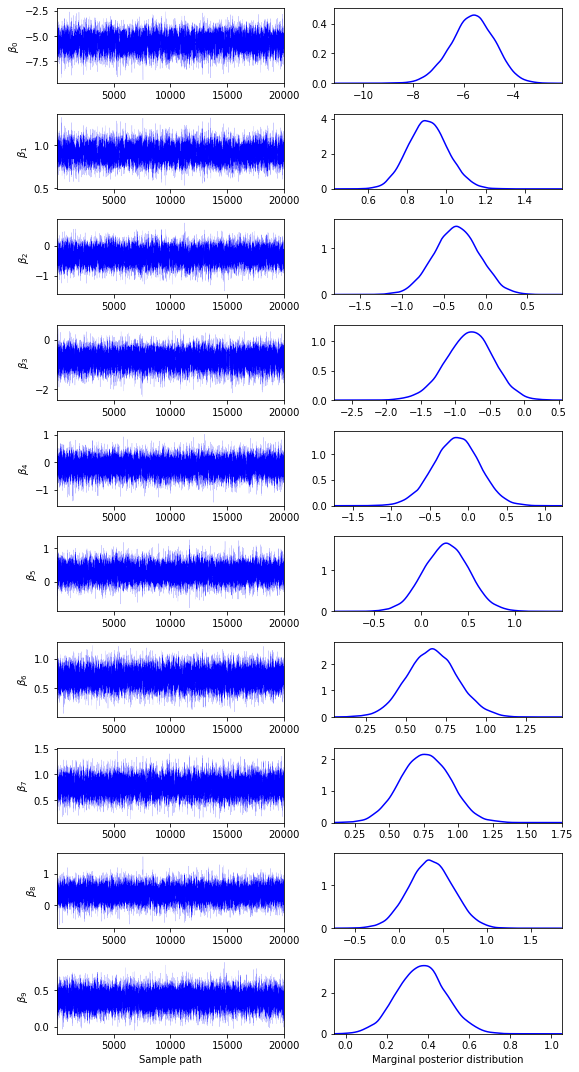

In [11]:
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for index in range(k):
    mc_trace = trace['b'][:, index]
    x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
    x_max =  mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 0].plot(mc_trace, 'b-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel('$\\beta_{:d}$'.format(index))
    ax[index, 1].plot(x, posterior, 'b-')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
ax[k-1, 0].set_xlabel('Sample path')
ax[k-1, 1].set_xlabel('Marginal posterior distribution')
plt.tight_layout()
# plt.savefig('ms_fig_ships.png', dpi=300)
plt.show()